## Variant 3: Add a few dropout layers in the model. Would the performance improve? Try 2 different ways to add the dropout layers. Describe the ones you tried and their performance.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets
from torch.utils.data.dataset import Dataset
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

In [2]:
""" A dataset wrapper class for applying transforms on the fly. """

class TransformDataset(Dataset):
    
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [3]:
# Define transformations
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
full_train_set = datasets.CIFAR10(root='./data', train=True, download=True)
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split the full training dataset into new training and validation datasets (80/20 split)
train_size = int(0.8 * len(full_train_set))
val_size = len(full_train_set) - train_size
train_indices, val_indices = torch.utils.data.random_split(range(len(full_train_set)), [train_size, val_size])

train_dataset = TransformDataset(Subset(full_train_set, train_indices), transform=transform_train)
val_dataset = TransformDataset(Subset(full_train_set, val_indices), transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


### Variant 3A: Dropout after fully connected layers

This variant introduces dropout after the fully connected layer except the output layer, aiming to control overfitting in the dense part of the network.

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class MiniVGG_Variant3A(nn.Module):
    def __init__(self):
        super(MiniVGG_Variant3A, self).__init__()

        # First convolutional block
        self.conv1_1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1_1 = nn.BatchNorm2d(64)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn1_2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)

        # Second convolutional block
        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2_1 = nn.BatchNorm2d(128)
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn2_2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Third convolutional block
        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3_1 = nn.BatchNorm2d(256)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn3_2 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2, 2)

        # Fully connected layers with dropout
        self.dropout_fc = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        # Convolutional blocks
        x = F.relu(self.bn1_1(self.conv1_1(x)))
        x = self.pool1(F.relu(self.bn1_2(self.conv1_2(x))))

        x = F.relu(self.bn2_1(self.conv2_1(x)))
        x = self.pool2(F.relu(self.bn2_2(self.conv2_2(x))))

        x = F.relu(self.bn3_1(self.conv3_1(x)))
        x = self.pool3(F.relu(self.bn3_2(self.conv3_2(x))))

        # Flatten and pass through dense layers with dropout
        x = x.view(-1, 256 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = self.fc2(x)

        return x

model_variant3A = MiniVGG_Variant3A()


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# Loss function and optimizer with weight decay
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_variant3A.parameters(), lr=0.0008, weight_decay=0.008)  # L2
# Initialize the StepLR scheduler
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_variant3A.to(device)

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=70):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        total_samples = 0
        running_loss = 0.0
        running_correct = 0

        # Training phase
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            running_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        epoch_train_loss = running_loss / total_samples
        epoch_train_acc = running_correct / total_samples
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc * 100)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        epoch_val_loss = val_loss / val_total
        epoch_val_acc = val_correct / val_total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc * 100)

        # Print training and validation results
        print(f'Epoch [{epoch+1}/{num_epochs}]: Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc * 100:.2f}%, Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc * 100:.2f}%')

        # Update the learning rate
        scheduler.step()

    return train_losses, val_losses, train_accuracies, val_accuracies


train_losses, val_losses, train_accuracies, val_accuracies = train_model(model_variant3A, train_loader, val_loader, criterion, optimizer, scheduler)

Epoch [1/70]: Train Loss: 1.9554, Train Acc: 29.65%, Val Loss: 1.6589, Val Acc: 42.63%
Epoch [2/70]: Train Loss: 1.5961, Train Acc: 42.29%, Val Loss: 1.4483, Val Acc: 48.98%
Epoch [3/70]: Train Loss: 1.4436, Train Acc: 48.11%, Val Loss: 1.3417, Val Acc: 52.86%
Epoch [4/70]: Train Loss: 1.3419, Train Acc: 51.49%, Val Loss: 1.2431, Val Acc: 56.47%
Epoch [5/70]: Train Loss: 1.2596, Train Acc: 55.01%, Val Loss: 1.1768, Val Acc: 58.94%
Epoch [6/70]: Train Loss: 1.1853, Train Acc: 57.81%, Val Loss: 1.1289, Val Acc: 60.23%
Epoch [7/70]: Train Loss: 1.1286, Train Acc: 59.91%, Val Loss: 1.0928, Val Acc: 61.71%
Epoch [8/70]: Train Loss: 1.0775, Train Acc: 61.87%, Val Loss: 1.0494, Val Acc: 62.95%
Epoch [9/70]: Train Loss: 1.0261, Train Acc: 63.62%, Val Loss: 0.9758, Val Acc: 65.88%
Epoch [10/70]: Train Loss: 0.9878, Train Acc: 65.28%, Val Loss: 0.9477, Val Acc: 66.36%
Epoch [11/70]: Train Loss: 0.9481, Train Acc: 66.90%, Val Loss: 0.9432, Val Acc: 67.17%
Epoch [12/70]: Train Loss: 0.9150, Train 

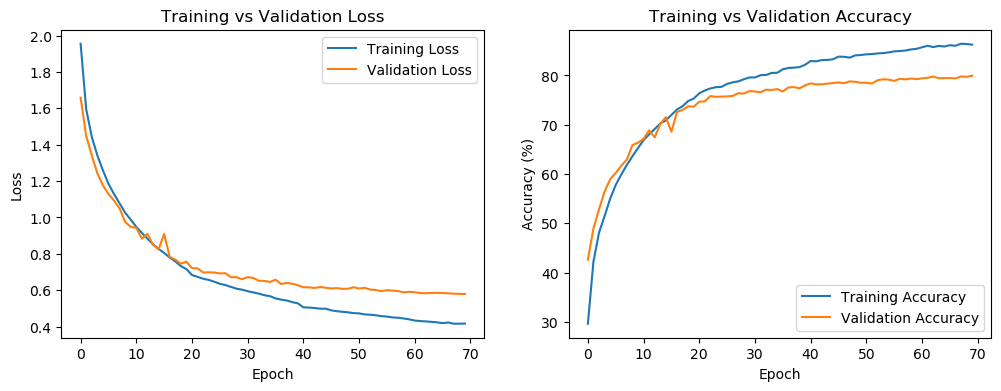

In [6]:
import matplotlib.pyplot as plt

def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()

plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)


In [7]:
model_variant3A.eval()  # Set the model to evaluation mode
test_corrects = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_variant3A(inputs)
        _, preds = torch.max(outputs, 1)
        test_corrects += torch.sum(preds == labels.data)

test_acc = test_corrects.double() / len(test_set)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7935


### Variant 3B: Dropout after each convolutional block
In this variant, dropout is added after each convolutional block. This can help to reduce overfitting by preventing complex co-adaptations on training data, potentially leading to a model that generalizes better to unseen data.

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class MiniVGG_Variant3B(nn.Module):
    def __init__(self):
        super(MiniVGG_Variant3B, self).__init__()

        # First convolutional block
        self.conv1_1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1_1 = nn.BatchNorm2d(64)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn1_2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.drop1 = nn.Dropout(0.1)

        # Second convolutional block
        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2_1 = nn.BatchNorm2d(128)
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn2_2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.drop2 = nn.Dropout(0.1)

        # Third convolutional block
        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3_1 = nn.BatchNorm2d(256)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn3_2 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.drop3 = nn.Dropout(0.1)

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        # Each convolutional block followed by pooling and dropout
        x = F.relu(self.bn1_1(self.conv1_1(x)))
        x = self.drop1(self.pool1(F.relu(self.bn1_2(self.conv1_2(x)))))

        x = F.relu(self.bn2_1(self.conv2_1(x)))
        x = self.drop2(self.pool2(F.relu(self.bn2_2(self.conv2_2(x)))))

        x = F.relu(self.bn3_1(self.conv3_1(x)))
        x = self.drop3(self.pool3(F.relu(self.bn3_2(self.conv3_2(x)))))

        # Flatten and pass through dense layers
        x = x.view(-1, 256 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

model_variant3B = MiniVGG_Variant3B()


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# Loss function and optimizer with weight decay
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_variant3B.parameters(), lr=0.0005, weight_decay=0.008)  # L2
# Initialize the StepLR scheduler
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_variant3B.to(device)

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=75):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        total_samples = 0
        running_loss = 0.0
        running_correct = 0

        # Training phase
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            running_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        epoch_train_loss = running_loss / total_samples
        epoch_train_acc = running_correct / total_samples
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc * 100)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        epoch_val_loss = val_loss / val_total
        epoch_val_acc = val_correct / val_total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc * 100)

        # Print training and validation results
        print(f'Epoch [{epoch+1}/{num_epochs}]: Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc * 100:.2f}%, Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc * 100:.2f}%')

        # Update the learning rate
        scheduler.step()

    return train_losses, val_losses, train_accuracies, val_accuracies


train_losses, val_losses, train_accuracies, val_accuracies = train_model(model_variant3B, train_loader, val_loader, criterion, optimizer, scheduler)

Epoch [1/75]: Train Loss: 2.0626, Train Acc: 27.32%, Val Loss: 1.8741, Val Acc: 33.99%
Epoch [2/75]: Train Loss: 1.7383, Train Acc: 38.25%, Val Loss: 1.6663, Val Acc: 40.38%
Epoch [3/75]: Train Loss: 1.5753, Train Acc: 43.64%, Val Loss: 1.5509, Val Acc: 43.33%
Epoch [4/75]: Train Loss: 1.4722, Train Acc: 47.29%, Val Loss: 1.4577, Val Acc: 47.08%
Epoch [5/75]: Train Loss: 1.3990, Train Acc: 49.92%, Val Loss: 1.3978, Val Acc: 49.50%
Epoch [6/75]: Train Loss: 1.3403, Train Acc: 52.23%, Val Loss: 1.3491, Val Acc: 51.92%
Epoch [7/75]: Train Loss: 1.2829, Train Acc: 54.48%, Val Loss: 1.2883, Val Acc: 52.86%
Epoch [8/75]: Train Loss: 1.2309, Train Acc: 56.29%, Val Loss: 1.2307, Val Acc: 56.32%
Epoch [9/75]: Train Loss: 1.1818, Train Acc: 58.57%, Val Loss: 1.2015, Val Acc: 57.60%
Epoch [10/75]: Train Loss: 1.1422, Train Acc: 59.62%, Val Loss: 1.1766, Val Acc: 58.66%
Epoch [11/75]: Train Loss: 1.1057, Train Acc: 60.96%, Val Loss: 1.1225, Val Acc: 60.07%
Epoch [12/75]: Train Loss: 1.0753, Train 

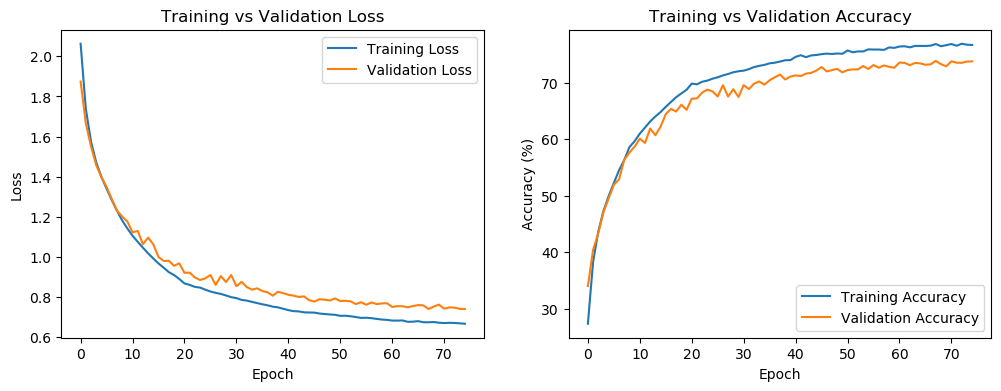

In [7]:
import matplotlib.pyplot as plt

def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()

plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)


In [8]:

model_variant3B.eval()  # Set the model to evaluation mode
test_corrects = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_variant3B(inputs)
        _, preds = torch.max(outputs, 1)
        test_corrects += torch.sum(preds == labels.data)

test_acc = test_corrects.double() / len(test_set)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7423


### Observation:
Test Accuracy for architecture with one dropout of 0.5 was better. This suggests that the model could generalise well in the dense part of the network.